In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from IPython.display import display
import json

# Part 1 ‑Exploratory data analysis

In [2]:
logins = pd.read_json('logins.json')
logins.sort_values('login_time', inplace=True)
display(logins.head(5))

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


In [4]:
logins = pd.read_json('logins.json')
logins.sort_values('login_time', inplace=True)
display(logins.head(5))

# Count
logins['counts'] = 1

# Generate prelim data analysis of different granularity
logins = logins.set_index('login_time')
min15 = logins.resample('15min').count()
hourly = logins.resample('H').count()
daily = logins.resample('D').count()

# Generate detailed daily data 
min_15 = min15.reset_index()
min15_mean = pd.DataFrame(min_15['login_time'].map(lambda d : d.time()))
min15_mean['counts'] = min_15['counts']
min15_mean = min15_mean.groupby('login_time').mean()
min15_median = min15_mean.groupby('login_time').median()

#display(daily_mean.head())

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


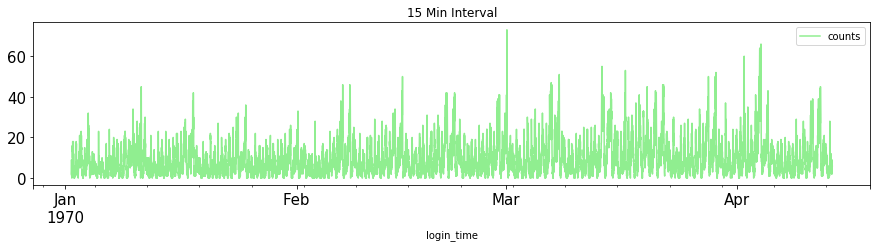

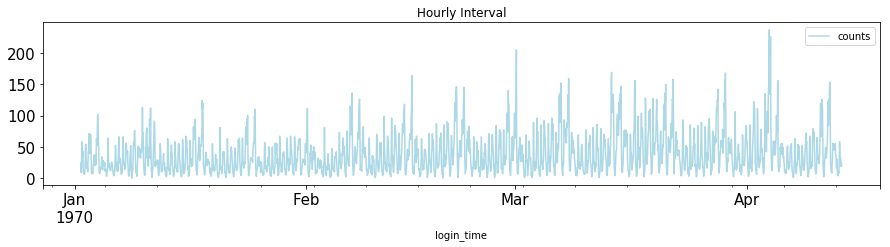

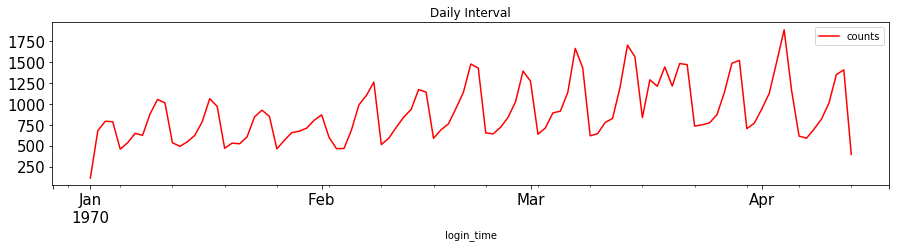

In [5]:
# Investigate patterns
min15.plot(figsize=(15, 3), color='lightgreen', title='15 Min Interval', fontsize=15)
hourly.plot(figsize=(15, 3), color='lightblue', title='Hourly Interval', fontsize=15)
daily.plot(figsize=(15, 3), color='red', title='Daily Interval', fontsize=15)
#min15_mean.plot(figsize=(15, 3), color='orange', title='min15_daily_mean', fontsize=15)
#daily_mean.plot(figsize=(20, 5), color='black', title='daily_in_a_week_median', fontsize=15)
#plt.plot(daily_mean.values.tolist)
plt.show()

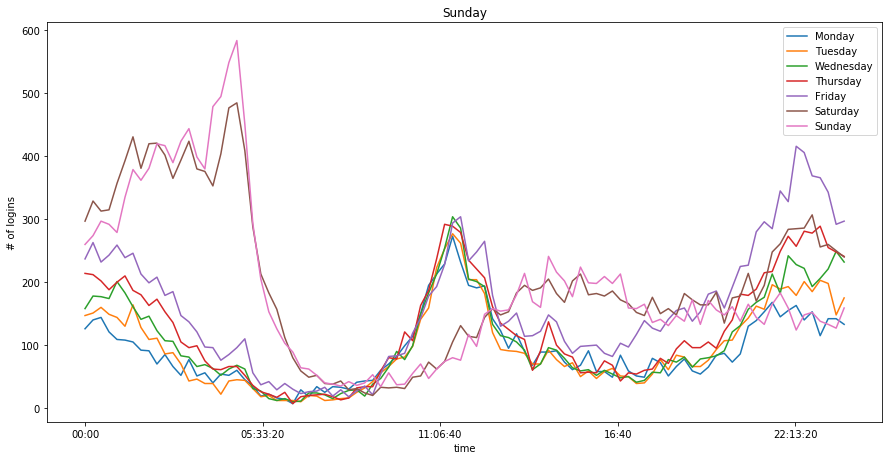

In [6]:
#dataframe with day of week
day_week = min15.reset_index()
day_week['dayofweek'] = day_week['login_time'].dt.dayofweek
day_week.set_index('login_time', inplace=True)

weekday = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
plt.figure(figsize=(12.5,6.5))

for d in range(7):

    day = day_week[day_week['dayofweek']==d]
    day = day.reset_index()
    d_day = pd.DataFrame(day['login_time'].apply(lambda d : d.time()))
    d_day['counts'] = day['counts']
    d_day = d_day.groupby('login_time').sum()
    
    plt.title(weekday[d])
    plt.plot(d_day['counts'], label=weekday[d])
    plt.ylabel('# of logins')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

From the daily interval cycle, we can see that the demand would peak at certain day of the week, with the peak increasing slightly moving from Winter to Spring. Looking closer to these demands on daily basis, we can see that these peaks are likely from the weekend periods, where averagely the demand peaked to about 400, 500, and 600 on Friday night, Saturday, and Sunday, respectively. It should be noted that users (or perhaps a different group of users) behave distinctly differeent on Saturdat and Sunday, where we can see that the peak time is in very early morning around 5 AM (That's definitely not me), whereas the other day of the weeks, user logins would peak during lunch break, except for the party days (Thursday, Friday, and Saturday) that it could peak again at late night. The quality of the data and analysis could be improved if we have more data, perhaps year round, as this trend may not be true the entire year.

# Part 2 ‑ Experiment and metrics design



The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

   1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
    
    **Ans:** I would take the change in number of toll reimbursement as the metrics because that is indicative that the plan does encourage more driver partner to go across cities. If we only take the
    activity of partners, that may be due to other factors that increases it that are not relavant to the plan.

   2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
   
    **Ans: A simple A/B testing should do the job.

        a. how you will implement the experiment
        
        **Ans:** Assign one control group that will not be given the reimbursement benefit, while the experimental group get the full benefit.

        b. what statistical test(s) you will conduct to verify the significance of the observation
        
        **Ans:** We can then use statistical test, such as z-test or t-test depending on sample size, to see if the mean value of number of reimbursement between these two groups are different.

        c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

        **Ans:** The null hypothesis is that these two group would have different mean value, if the result of the test yielded p-value above 0.05, then we do not reject the hypothesis. Some caveats include the sample size, if the sample size is not big enough, it may not be representative of the entire cities. Plus, other factors could easily affect the driving behavior of the driving partners.

# Part 3 ‑ Predictive Modeling

## Preprocessing

In [7]:
# Impoting data
with open("ultimate_data_challenge.json") as file:
    df = pd.DataFrame(json.load(file))
display(df.head())

# Check NaN 
display(df.isnull().any())

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
dtype: bool

In [8]:
# Fill NaN by mean
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())
df['phone'] = df['phone'].fillna('Others')

print(df['phone'].value_counts())

# Cnvert bollean to 0 and 1
df['ultimate_black_user'] = df['ultimate_black_user'].apply(lambda x: 1 if x else 0)

iPhone     34582
Android    15022
Others       396
Name: phone, dtype: int64


In [9]:
# Making date time
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

# Adding active if they have been active 30 days prior to when the data was pulled
df['active'] = [1 if x > pd.Timestamp('2014-06-01') else 0 for x in df['last_trip_date']]

display(df.describe())

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.00000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,0.37708,60.926084,0.36620
std,5.707357,0.445753,0.564977,0.222336,19.958811,3.792684,0.48466,37.081503,0.48177
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.00000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,0.00000,33.300000,0.00000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,0.00000,66.700000,0.00000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,1.00000,100.000000,1.00000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,1.00000,100.000000,1.00000


## EDA

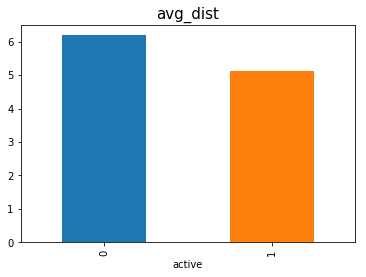

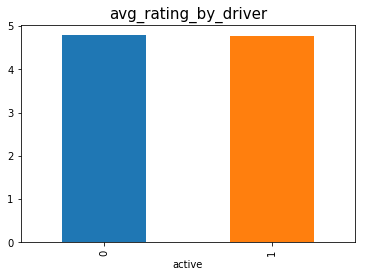

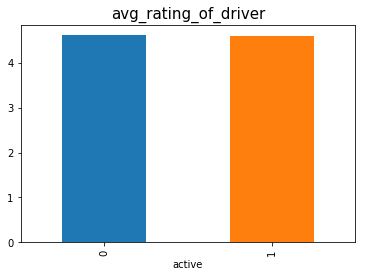

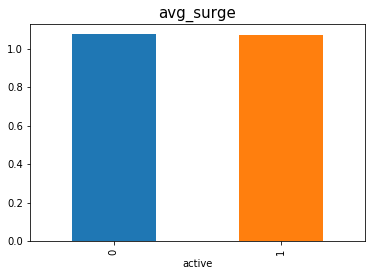

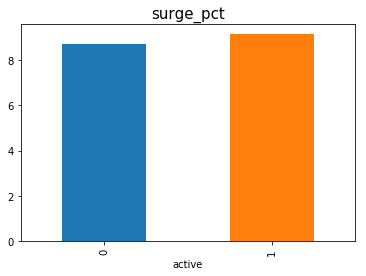

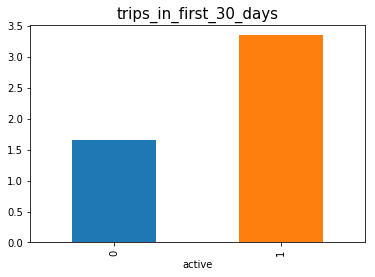

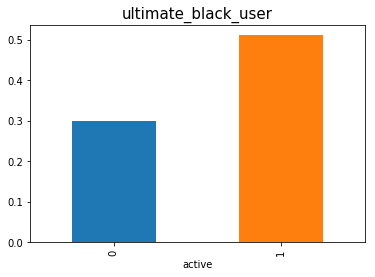

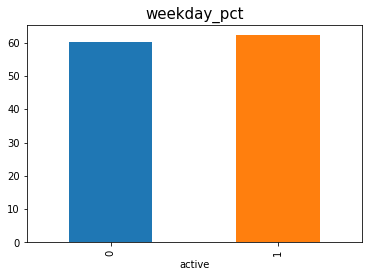

In [50]:
# Looking at numeric columns
for i, column in enumerate(df.groupby('active').mean().columns):
    df.groupby('active').mean().iloc[:, i].plot(kind='bar')
    plt.title(column, fontsize=15)
    plt.show()

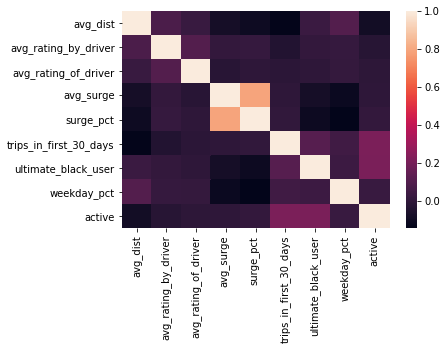

In [11]:
# Looking at numeric columns
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

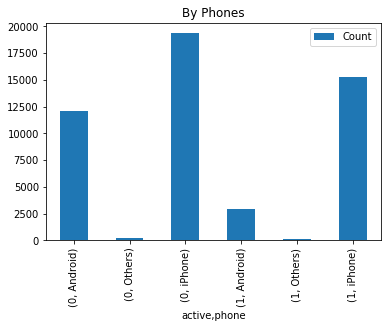

In [12]:
# Looking at categorical columns
by_phone = df.groupby(['active', 'phone']).count()[['avg_dist']].rename(columns={'avg_dist':'Count'})
by_phone.plot(kind='bar')
plt.title('By Phones')
plt.show()

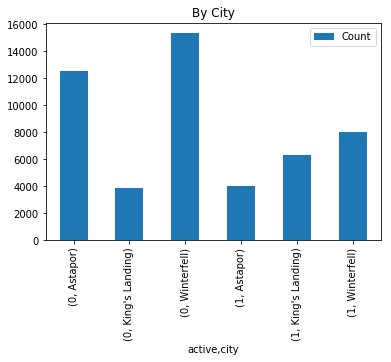

In [13]:
# Looking at categorical columns
by_phone = df.groupby(['active', 'city']).count()[['avg_dist']].rename(columns={'avg_dist':'Count'})
by_phone.plot(kind='bar')
plt.title('By City')
plt.show()

From preliminary data analysis we can see that there's a significant difference between active and non-active users in the feature 'city', 'phone', 'ultimate_black_user', 'trips_in_first_30_days', and 'avg dist'. However, by using just these feature I got slightly lower f1 score than employing all features. Therefore in the following model I employed all the features.

# Building Model

## Feature Engineering

In [21]:
# Get dummy variables
from scipy import stats
def two_param_boxcox(data):
    data += 1
    data, _ = stats.boxcox(data)
    return data

data = pd.get_dummies(df.drop(['last_trip_date', 'signup_date'], axis=1), columns=['phone', 'city'])
display(data.head())

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active,phone_Android,phone_Others,phone_iPhone,city_Astapor,city_King's Landing,city_Winterfell
0,3.67,5.0,4.7,1.10,15.4,4,1,46.2,1,0,0,1,0,1,0
1,8.26,5.0,5.0,1.00,0.0,0,0,50.0,0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,0.0,3,0,100.0,0,0,0,1,1,0,0
3,2.36,4.9,4.6,1.14,20.0,9,1,80.0,1,0,0,1,0,1,0
4,3.13,4.9,4.4,1.19,11.8,14,0,82.4,0,1,0,0,0,0,1


Before


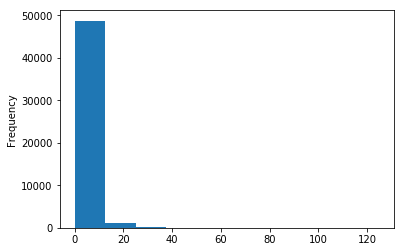

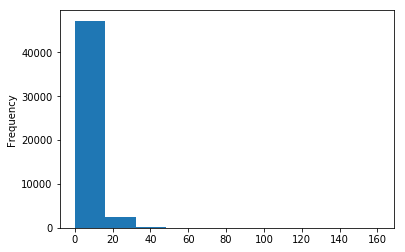

After


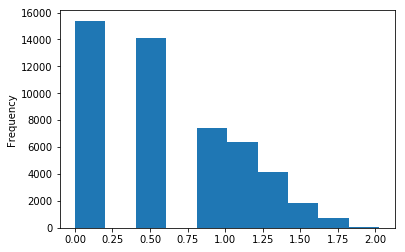

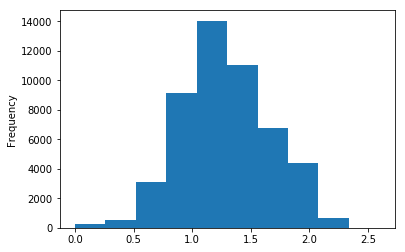

In [22]:
# Normalize the data distribution using boxcox transformation
print('Before')
# See the distribution of the selected numerical data
data['trips_in_first_30_days'].plot.hist()
plt.show()
data['avg_dist'].plot.hist()
plt.show()

data['avg_dist'] = two_param_boxcox(data['avg_dist'].values)
data['trips_in_first_30_days'] = two_param_boxcox(data['trips_in_first_30_days'].values)

print('After')
data['trips_in_first_30_days'].plot.hist()
plt.show()
data['avg_dist'].plot.hist()
plt.show()

#data = data.dropna()

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

y = data['active']
X = data.drop(['active'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
# Compare models using k-fold cross validation
kfold = StratifiedKFold(n_splits=3, random_state=42)

clfs = [SVC(), RandomForestClassifier(n_estimators=100)]
results = []

for clf in clfs:
    results += [cross_validate(estimator=clf, X=X_train, y=y_train, cv=kfold, scoring=scoring, return_train_score=False)]

In [25]:
results 

[{'fit_time': array([32.30184746, 30.86276531, 32.50385928]),
  'score_time': array([28.09060669, 27.91559649, 28.31061912]),
  'test_accuracy': array([0.77792, 0.77128, 0.76984]),
  'test_f1_score': array([0.67600373, 0.6648693 , 0.66658941]),
  'test_precision': array([0.72581454, 0.7174298 , 0.70994816]),
  'test_recall': array([0.63259065, 0.61948449, 0.62822193])},
 {'fit_time': array([2.29013109, 2.21212673, 2.21912718]),
  'score_time': array([1.3460772 , 1.10406303, 1.14306521]),
  'test_accuracy': array([0.76552, 0.76216, 0.76392]),
  'test_f1_score': array([0.67335339, 0.66561692, 0.67068408]),
  'test_precision': array([0.68737201, 0.68606538, 0.68560347]),
  'test_recall': array([0.65989515, 0.64635212, 0.65640017])}]

In [34]:
# Learn about the feature importance a bit so taht we can have more insight to actionable decisions

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("{}. feature {} ({})".format(f + 1, X_train.keys()[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature avg_dist (0.2920734045360498)
2. feature weekday_pct (0.13389942583439265)
3. feature avg_rating_by_driver (0.11549713071576112)
4. feature surge_pct (0.08322682150803401)
5. feature avg_rating_of_driver (0.0808008900366572)
6. feature trips_in_first_30_days (0.07689695584463908)
7. feature avg_surge (0.06615915623569274)
8. feature city_King's Landing (0.04851090289171244)
9. feature ultimate_black_user (0.03344305361107803)
10. feature phone_Android (0.02077384697878061)
11. feature phone_iPhone (0.019921684688996345)
12. feature city_Astapor (0.01751765736444198)
13. feature city_Winterfell (0.01012266033847317)
14. feature phone_Others (0.0011564094152907854)


In [44]:
# Optimize the model (SVC was slightly better)

from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'max_features':('auto', 'log2')}

clf = GridSearchCV(RandomForestClassifier(), parameters, scoring=make_scorer(f1_score))
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'max_features': ('auto', 'log2')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=0)

In [47]:
y_pred = clf.best_estimator_.predict(X_test) 
print('F1 score for the test set is {:.2f}.'.format(f1_score(y_test, y_pred)))

F1 score for the test set is 0.67.


How valid is your model? Include any key indicators of model performance.

**Ans:** The model is valid as it has been tested with stratefied k-fold cross validation. The model performace was primarily measured by F1 score, which takes into account both precision and recall. Our model achieved F1 score of 0.67 in the test set by using random forest (although using SVC could increase f1 score slightly bit, but it takes much longer to train).

Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice)

**Ans:** The insight from the feature importance by random forest suggested that avg_dist is the most important feature, and when combined with EDA, we can see that driver with lower average distance in miles per trip taken in the first 30 days after signup tends to stay active longer. This indicates that users who travel shorter distances tends to stay active, and therefore the company could provide more promotion for this type of users to further incease the number of users of this kind. On the other end of feature importance, the company needs not to worry about what type of phone the users are using or which city the users are from.